In [46]:
import sys
import numpy as np
import pandas as pd

%matplotlib inline

In [47]:
print(sys.version)

3.4.3 (default, Apr  3 2015, 14:52:06) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


## Plotting 

To plot our technical indicators we will use a reusabled function `plot`:

In [48]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
    
def plot(stock, overlays = [], subplots = []):
    fig = plt.figure()
    plt.figure(figsize=(14,6))
    plt.rc('axes', color_cycle=['#31a354', '#3182bd', '#e6550d', '#de2d26', '#c51b8a'])

    left, width = 0.1, 2
    
    subplot_bottom = 0.25

    rect = [left, subplot_bottom + 0.04, width, 1]

    fillcolor = 'darkgoldenrod'

    ax = fig.add_axes(rect)
    axt = ax.twinx()

    closing, = ax.plot(stock.index, stock.closing, label='Price')
    
    plt_handles = []
    
    if len(overlays) > 0:
        for overlay in overlays:
            kargs = overlay[1]
            handle, = ax.plot(stock.index, overlay[0], **kargs)
            
    if len(subplots) > 0:
        ax.set_xticks([])
        sp_rec = [left, 0, width, 0.25]
        sp_ax = fig.add_axes(sp_rec, sharex=ax)
        
        for subplot in subplots:
            if len(subplot) == 3 and subplot[2] == 'hist':
                sp_ax.fill_between(stock.index, subplot[0], 0, alpha=0.5, facecolor='#777777', edgecolor='#777777')
            else:
                kargs = subplot[1]
                handle, = sp_ax.plot(stock.index, subplot[0], **kargs)
            
        props = font_manager.FontProperties(size=10)
        sp_leg = sp_ax.legend(loc='upper left', prop=props)
        sp_leg.get_frame().set_alpha(0.8)
    
    volume = (stock.closing*stock.turnover)/1e6  # dollar volume in millions
    vmax = volume.max()
    poly = axt.fill_between(stock.index, volume, 0, label='Volume', facecolor=fillcolor, edgecolor=fillcolor)
    axt.set_ylim(0, 5*vmax)
    axt.set_yticks([])

    props = font_manager.FontProperties(size=10)
    leg = ax.legend(loc='upper left', prop=props)
    leg.get_frame().set_alpha(0.8)

    plt.show()

## Retreiving a Quote

In [49]:
symbol = 'LUCK'

stock_prices = pd.read_csv('data/2014.csv')
stock = stock_prices[stock_prices.symbol == symbol]


stock = stock.set_index('date')
stock.index = pd.to_datetime(stock.index)

stock.head()

,symbol,ldcp,open,high,low,closing,turnover
2014-01-01,LUCK,299.87,301.90,312.00,301.88,310.60,275100
2014-01-02,LUCK,310.60,311.99,322.95,311.00,321.67,643800
2014-01-03,LUCK,321.67,323.50,325.99,316.35,317.60,218700
2014-01-06,LUCK,317.60,317.99,321.49,315.00,316.43,122100
2014-01-07,LUCK,316.43,316.50,317.45,309.53,314.79,249300


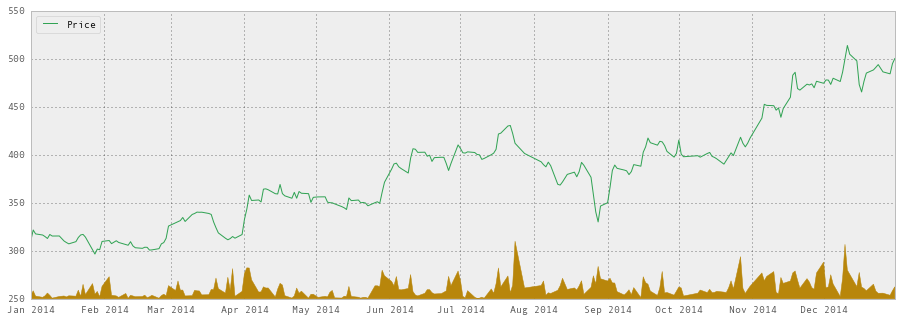

In [50]:
plot(stock)

## Moving Average

**Moving Average (MA)** smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period.

We'll calculate moving averages for the period of 20 and 50 days:

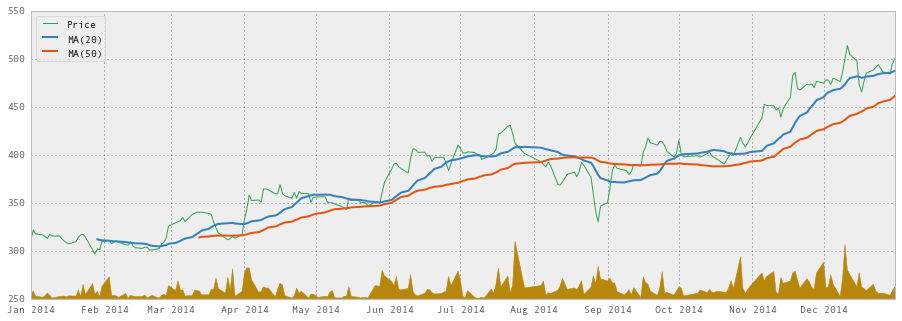

In [51]:
ma20 = pd.rolling_mean(stock.closing, window = 20)
ma50 = pd.rolling_mean(stock.closing, window = 50)


plot(stock, overlays = [
    [ma20, {'label':'MA(20)', 'lw': 2}],
    [ma50, {'label':'MA(50)', 'lw': 2}]
])

## Exponential Moving Average

A type of moving average that is similar to a simple moving average, except that more weight is given to the latest data.

#### Calculation:

**Multiplier:** (2 / (Time Periods + 1) )

**EMA:** {Close - EMA(previous day)} x Multiplier + EMA(previous day)

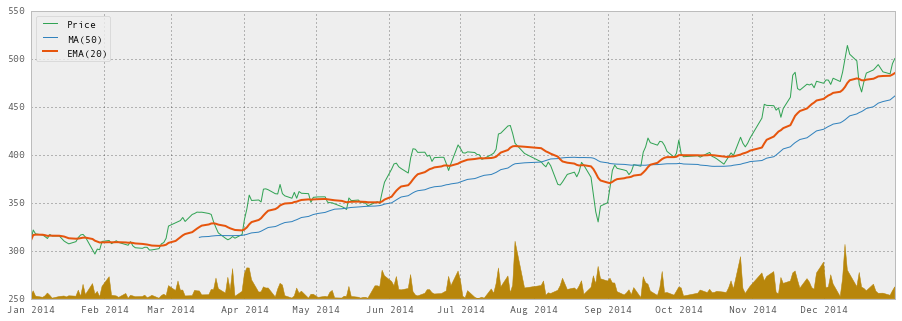

In [53]:
ema20 = pd.ewma(stock.closing, span = 20)

plot(stock, overlays = [
    [ma50, {'label':'MA(50)'}],
    [ema20, {'label':'EMA(20)', 'lw': 2}]
])

## Bollinger Bands 

Bollinger Bands are volatility bands placed above and below a moving average. Volatility is based on the standard deviation, which changes as volatility increases and decreases. The bands automatically widen when volatility increases and narrow when volatility decreases. 

#### Calculation:
**Middle Band** = 20-day simple moving average (SMA)

**Upper Band** = 20-day SMA + (20-day standard deviation of price x 2) 

**Lower Band** = 20-day SMA - (20-day standard deviation of price x 2)

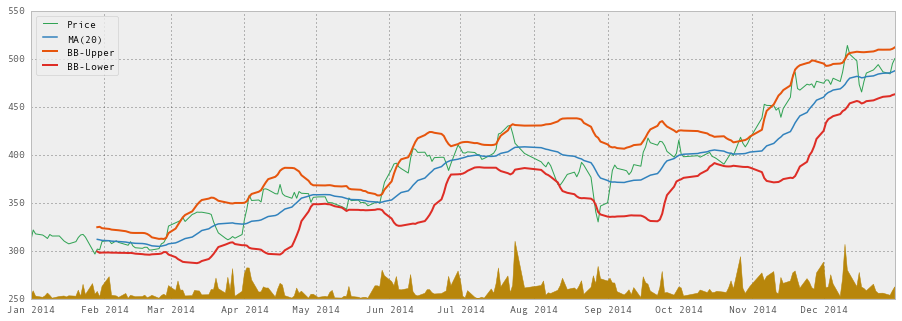

In [54]:
bb_upper = ma20 + 2 * pd.rolling_std(stock.closing, 20, min_periods=20)
bb_lower = ma20 - 2 * pd.rolling_std(stock.closing, 20, min_periods=20)

plot(stock, overlays = [
    [ma20, {'label':'MA(20)', 'lw': 1.5}],
    [bb_upper, {'label':'BB-Upper', 'lw': 2}],
    [bb_lower, {'label':'BB-Lower', 'lw': 2}]
])

## Price Channels 

Price Channels are lines set above and below the price of a security. 

**Upper Channel Line:** 20-day High

**Lower Channel Line:** 20-day Low

**Centerline:** (20-day High + 20-day Low)/2 

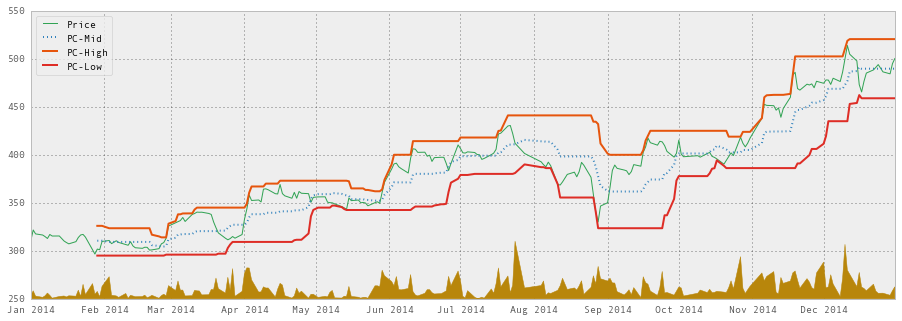

In [55]:
pc_high = pd.rolling_max(stock.high, window = 20)
pc_low = pd.rolling_min(stock.low, window = 20)
pc_mid = (pc_high + pc_low) / 2

plot(stock, overlays = [
    [pc_mid, {'label':'PC-Mid', 'linewidth': 2, 'ls':':'}],
    [pc_high, {'label':'PC-High', 'linewidth': 2}],
    [pc_low, {'label':'PC-Low', 'linewidth': 2}]
])

## Average True Range

The Average True Range (ATR) is an indicator that measures volatility.

#### Calculation:

First we determine our **true ranage (TR)**:

TR = MAX(High – Low, ABS(Hight – LDCP), ABS(LDCP – Low)) 

Then our **ATR** is:
$$
ATR = \frac{1}{n} \sum_{i=1}^{n} TR_i
$$


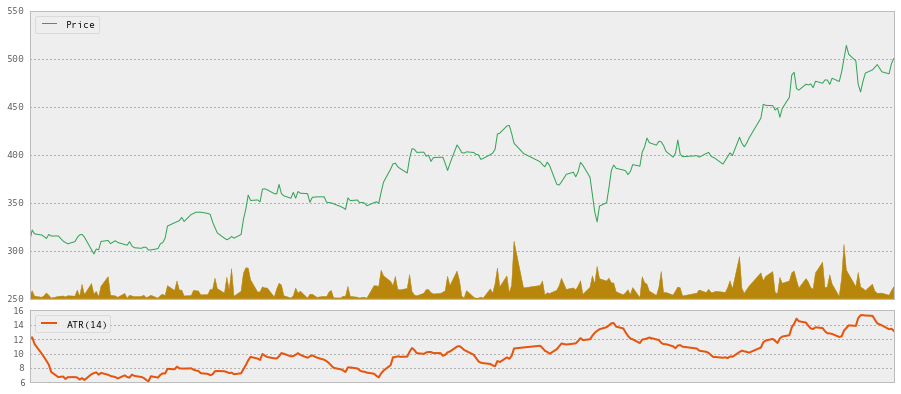

In [56]:
tr = pd.DataFrame(index=stock.index, columns=['value'])

for index, row in stock.iterrows(): # determining our True Range
    tr.ix[index]['value'] = max(row.high, row.ldcp) - min(row.low, row.ldcp)

atr14 = pd.ewma(tr.value, com = 14)

plot(stock, subplots = [
    [atr14, {'label':'ATR(14)', 'lw': 2, 'c': '#e6550d'}]
])

## Keltner Channels 

Keltner Channels are volatility-based envelopes set above and below an exponential moving average. This indicator is similar to Bollinger Bands, which use the standard deviation to set the bands. Instead of using the standard deviation, Keltner Channels use the Average True Range (ATR) to set channel distance. 

**Middle Line:** 20-day exponential moving average 

**Upper Channel Line:** 20-day EMA + (2 x ATR(10))

**Lower Channel Line:** 20-day EMA - (2 x ATR(10))

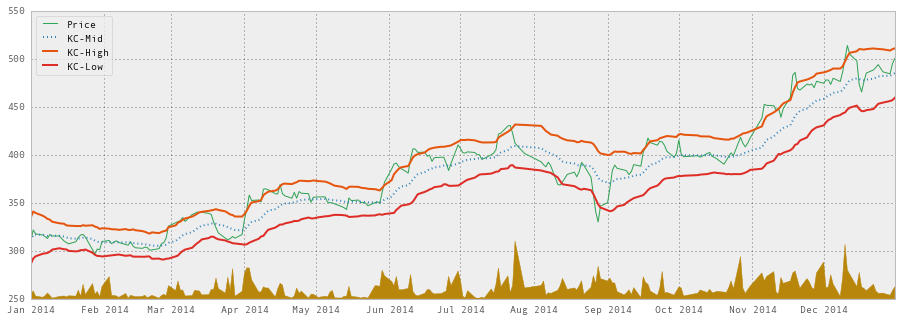

In [57]:
atr10 = pd.ewma(tr.value, com = 10)
kc_high = ema20 + (2 * atr10)
kc_low = ema20 - (2 * atr10)

plot(stock, overlays = [
    [ema20, {'label':'KC-Mid', 'lw': 2, 'ls':':'}],
    [kc_high, {'label':'KC-High', 'lw': 2}],
    [kc_low, {'label':'KC-Low', 'lw': 2}]
])

## Parabolic SAR 

Parabolic SAR is a trend following system constantly tailing the price action. It is a time series of stop-level points, portrayed on the chart in the form of dots, plotted below or above each price mark. A dot placed below the price is deemed to be a **bullish** signal while a dot placed above the prices is considered to be a **bearish** indicator. 

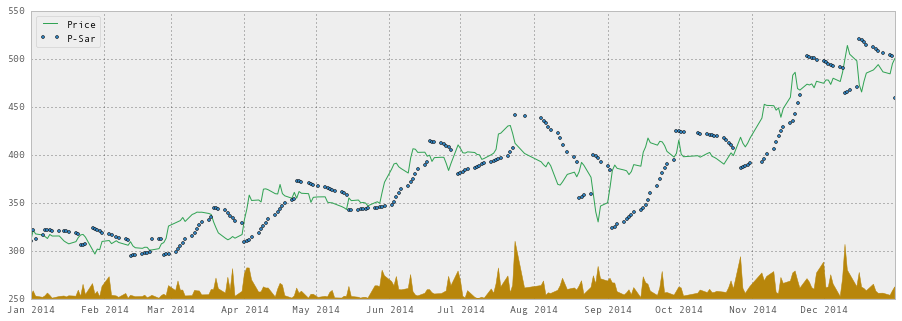

In [58]:
def psar(stock, iaf = 0.02, maxaf = 0.2):
    length = len(stock.index)
    dates = list(stock.index)
    high = list(stock.high.values)
    low = list(stock.low.values)
    close = list(stock.closing.values)
    psar = close[0:len(close)]

    bull = True
    af = iaf
    ep = low[0]
    hp = high[0]
    lp = low[0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = iaf
        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]

    return  pd.DataFrame({
            "dates":dates, 
            "high":high, 
            "low":low, 
            "close":close, 
            "psar":psar})

ps = psar(stock)

plot(stock, overlays = [
    [ps.psar, {'label':'P-Sar', 'lw': 3, 'ls':'', "marker":'o', "ms": 3}]
])

## Relative Strength Index 

A technical momentum indicator that compares the magnitude of recent gains to recent losses in an attempt to determine overbought and oversold conditions of an asset. It is calculated using the following formula:

**RSI = 100 - 100/(1 + RS*)**

_Where RS = Average of x days' up closes / Average of x days' down closes._

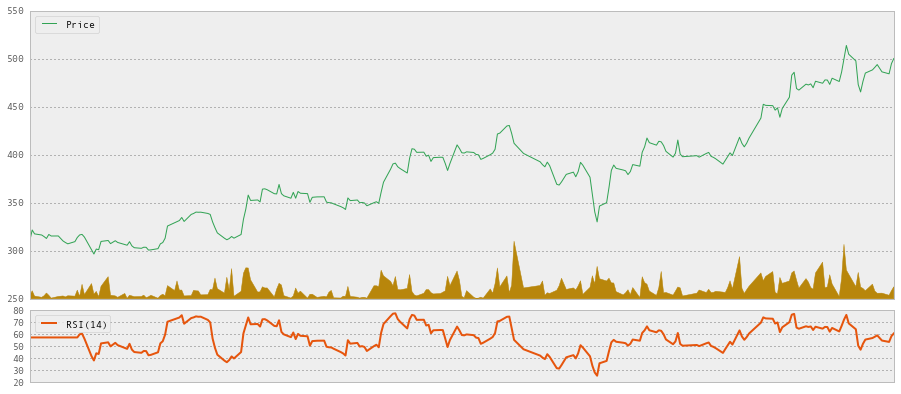

In [59]:
n = 14
deltas = np.diff(stock.closing.values)
seed = deltas[:n+1]
up = seed[seed>=0].sum()/n
down = -seed[seed<0].sum()/n

rs = up/down
rsi = np.zeros_like(stock.closing.values)

rsi[:n] = 100. - 100./(1.+rs)

for i in range(n, len(stock.closing.values)):
    delta = deltas[i-1] # cause the diff is 1 shorter

    if delta>0:
        upval = delta
        downval = 0.
    else:
        upval = 0.
        downval = -delta

    up = (up*(n-1) + upval)/n
    down = (down*(n-1) + downval)/n

    rs = up/down
    rsi[i] = 100. - 100./(1.+rs)

plot(stock, subplots = [
    [rsi, {'label':'RSI(14)', 'lw': 2, 'c': '#e6550d'}]
])

## Moving Average Convergence Divergence (MACD) 

Moving Average Convergence/Divergence oscillator (MACD) turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.

#### Calculation:

**MACD Line:** (12-day EMA - 26-day EMA)

**Signal Line:** 9-day EMA of MACD Line

**MACD Histogram:** MACD Line - Signal Line

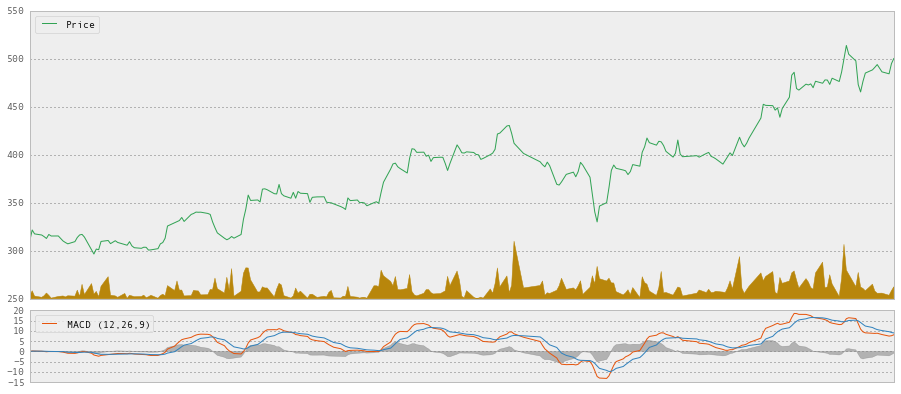

In [60]:
macd_line = pd.ewma(stock.closing, span = 12) - pd.ewma(stock.closing, span = 26)
macd_signal = pd.ewma(macd_line, span = 9)
macd_hist = macd_line - macd_signal

plot(stock, subplots = [
    [macd_line, {'label':'MACD (12,26,9)', 'lw': 1, 'c': '#e6550d'}],
    [macd_signal, {'lw': 1}],
    [macd_hist, {'lw': 1}, 'hist']
])

```
233: [16.377041792762498, 15.031205755552842, 1.345836037209656]
234: [15.994333572576693, 15.223831318957611, 0.7705022536190818]
235: [13.545039855079835, 14.888073026182056, -1.3430331711022205]
236: [10.86146170199737, 14.08275076134512, -3.2212890593477486]
237: [9.514254183747596, 13.169051445825614, -3.6547972620780182]
238: [9.038758217212887, 12.342992800103069, -3.3042345828901816]
239: [8.827258434688986, 11.639845927020252, -2.812587492331266]
240: [8.773151671347591, 11.06650707588572, -2.2933554045381292]
241: [8.859727265067534, 10.625151113722083, -1.7654238486545495]
242: [8.222716949434243, 10.144664280864514, -1.921947331430271]
243: [7.46719357451434, 9.609170139594479, -2.141976565080139]
244: [7.634151687331951, 9.214166449141974, -1.5800147618100233]
245: [8.104741072732281, 8.992281373860035, -0.8875403011277534]
```

In [44]:
macd_line.tail(), macd_signal.tail(), macd_hist.tail()

(2014-12-24    8.859726
 2014-12-26    8.222715
 2014-12-29    7.467192
 2014-12-30    7.634150
 2014-12-31    8.104740
 dtype: float64, 2014-12-24    10.625149
 2014-12-26    10.144662
 2014-12-29     9.609168
 2014-12-30     9.214164
 2014-12-31     8.992280
 dtype: float64, 2014-12-24   -1.765423
 2014-12-26   -1.921947
 2014-12-29   -2.141976
 2014-12-30   -1.580014
 2014-12-31   -0.887540
 dtype: float64)